In [1]:
import zipfile
import numpy as np
from tqdm import tqdm

from nltk.tokenize import wordpunct_tokenize
from gensim.models import Word2Vec, KeyedVectors

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
sns.set_style('darkgrid')

from data import Downloader, Parser

# Data loading

In [2]:
data_path = './data/'

In [3]:
# downloader = Downloader(data_path=data_path)

In [4]:
# downloader.run()

In [5]:
parser = Parser(data_path=data_path)

In [6]:
unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [03:34<00:00,  5.66s/it]


In [7]:
unlabeled = unlabeled[~unlabeled.question.isna()]
train = train[~train.question.isna()]
valid = valid[~valid.question.isna()]

In [8]:
set(train.category.unique().tolist()) == set(valid.category.unique().tolist())

True

In [9]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())
category2index = {category: index for index, category in enumerate(unique_categories)}

In [10]:
category2index

{'sports and outdoors': 0,
 'automotive': 1,
 'office products': 2,
 'baby': 3,
 'beauty': 4,
 'pet supplies': 5,
 'cell phones and accessories': 6,
 'grocery and gourmet food': 7}

In [11]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [12]:
train.head()

,question,response,category,target
0,2 questions. 1st question: holster size i'm th...,"yes, get the large size holster.",sports and outdoors,0
1,will these fit the 2008 highlander sport,"yes,they can custom build a front mat for your...",automotive,1
2,can an indian ringneck live in this cage??,not really.,pet supplies,5
3,are the buttons (power/volume) hard to push wi...,"nah, everything is perfect it's as if you don'...",cell phones and accessories,6
4,my cold air intake from k&amp;n has a bad turb...,me too i am wondering if the computer should b...,automotive,1


In [13]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

# Word embeddings

## Loading word embeddings

In [14]:
# with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

In [15]:
model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [16]:
print(model.most_similar('teacher'))

[('teachers', 0.7878414392471313), ('educator', 0.7609370946884155), ('Teacher', 0.7341679334640503), ('student', 0.7071880102157593), ('pupil', 0.7035911083221436), ('schoolteacher', 0.702113151550293), ('school', 0.6894515156745911), ('classroom', 0.6704409122467041), ('instructor', 0.6594052314758301), ('professor', 0.6570422649383545)]


## Fine-tuning the embeddings

Let us use gensim to fine-tune our embeddings on all questions in the data, including the unlabeled ones.

In [17]:
model_2 = Word2Vec(size=300, min_count=1)
model_2.build_vocab([list(model.vocab.keys())])

del model

In [18]:
w2v_data = [wordpunct_tokenize(sent) for sent in tqdm(train_x + valid_x + list(unlabeled.question))]
print(f'No. of sentences: {len(w2v_data)}.')
print(f'No. of tokens: {sum(len(x) for x in w2v_data)}.')

100%|██████████| 437280/437280 [00:03<00:00, 118045.78it/s]


No. of sentences: 437280.
No. of tokens: 7350506.


In [19]:
model = model_2
model_2.intersect_word2vec_format('wiki-news-300d-1M.vec', lockf=1.0)
model.train(w2v_data, total_examples=len(w2v_data), epochs=10);

# Data preprocessing

## Length distribution

In [20]:
train_lengths = [len(wordpunct_tokenize(sample)) for sample in tqdm(train_x)]

100%|██████████| 250000/250000 [00:02<00:00, 119159.72it/s]


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


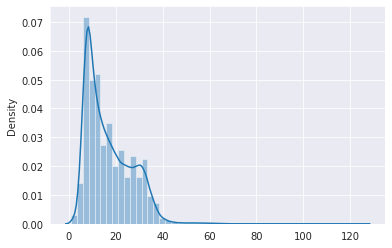

In [22]:
sns.distplot(train_lengths);

In [23]:
np.percentile(train_lengths, 95)

34.0

## pyTorch Dataset

In [24]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, pad_index=0, max_length=34):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenize(self, text):
        tokens = wordpunct_tokenize(text)
        token_indices = [model.wv.vocab[token].index for token in tokens if token in model.wv.vocab]
        
        return token_indices
    
    def __getitem__(self, index):
        text = self.texts[index]
        tokenized_text = self.tokenize(text)[:self.max_length]
        tokenized_text = torch.tensor(tokenized_text)
        
        target = self.targets[index]
        
        return tokenized_text, target

In [25]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y)

## pyTorch DataLoader

In [26]:
def pad(data):
    sorted_data = sorted(data, key=lambda x: -len(x[0]))
    sequence = [x[0] for x in sorted_data if len(x[0])]
    target = torch.LongTensor([x[1] for x in sorted_data if len(x[0])])
    
    packed_sequence = pack_sequence(sequence)
    
    return packed_sequence, target

In [27]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, collate_fn=pad)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, collate_fn=pad)

# Neural network

In [28]:
embeddings = torch.from_numpy(model.wv.vectors)
embeddings.shape

torch.Size([999994, 300])

In [40]:
class ClassificationModel(nn.Module):
    
    def __init__(self,
                 embeddings: torch.FloatTensor,
                 n_classes: int,
                 lstm_size: int = 512,
                 num_layers: int = 2,
                 bidirectional: bool = True,
                 residual: bool = True,
                 dropout_rate: float = 0.25,
                 spatial_dropout_rate: float = 0.25,
                 embedding_lr: float = 1e-4,
                 lr: float = 5e-3,
                 device: str = 'cpu'):
        
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=False, padding_idx=0)
        
        self.lstms = nn.ModuleList([nn.LSTM(input_size=embeddings.shape[1], hidden_size=lstm_size,
                                            bidirectional=bidirectional, batch_first=True)])
        self.lstms.extend([nn.LSTM(input_size=lstm_size * (2 if bidirectional else 1), hidden_size=lstm_size,
                                   bidirectional=bidirectional, batch_first=True) for _ in range(num_layers - 1)])
        
        self.linear = nn.Linear(lstm_size * (2 if bidirectional else 1), n_classes)
        
        self.spatial_dropout = nn.Dropout2d(spatial_dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.residual = residual
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            [
                {'params': self.embedding_layer.parameters(), 'lr': embedding_lr},
                {'params': self.lstms.parameters()},
                {'params': self.linear.parameters()}
            ],
            lr=lr
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.5,
                                                                    patience=1, threshold=0.1, min_lr=1e-5)
        
        self.train_losses = []
        self.train_epoch_losses = []
        self.valid_epoch_losses = []
        self.epoch_metrics = []
        
        self.device = device
        self.to(device)
        
    def apply_dropout(self, x):
        x, lengths = pad_packed_sequence(x, batch_first=True, padding_value=0)
        x = self.dropout(x)
        x = pack_padded_sequence(x, lengths, batch_first=True)
        
        return x
    
    def apply_spatial_dropout(self, x):
        x = x.unsqueeze(2)  # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = self.spatial_dropout(x)
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        
        return x
        
    def forward(self, x):
        x, lengths = pad_packed_sequence(x, batch_first=True, padding_value=0)
        x = self.embedding_layer(x)
        x = self.apply_spatial_dropout(x)
        x = pack_padded_sequence(x, lengths, batch_first=True)
        x, _ = self.lstms[0](x)
        x = self.apply_dropout(x)
        
        for lstm in self.lstms[1:]:
            prev_x = x
            x, _ = lstm(x)
            x = self.apply_dropout(x)
            if self.residual:
                prev_x, _ = pad_packed_sequence(prev_x, batch_first=True, padding_value=0)
                x, lengths = pad_packed_sequence(x, batch_first=True, padding_value=0)
                x += prev_x
                x = pack_padded_sequence(x, lengths, batch_first=True)
        
        x, lengths = pad_packed_sequence(x, batch_first=True, padding_value=0)
        x = x[torch.arange(x.shape[0]), lengths - 1, :]  # get hidden states for last item in each sequence
        
        x = self.linear(x)
        
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs: int = 100, verbose: bool = True):
        best_valid_loss = float('inf')
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            
            self.train()
            
            correct, total = 0, 0
            train_epoch_losses = []
            
            pbar = tqdm(total=len(train_loader), disable=not verbose, desc='Current progress: ',
                        position=0, leave=True)
            
            for x, y in train_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                
                logits = self.forward(x)
                
                loss = self.criterion(logits, y)
                self.train_losses.append(loss.item())
                train_epoch_losses.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                probs = F.softmax(logits, dim=-1)
                preds = probs.argmax(dim=-1)
                correct += (preds == y).long().sum().item()
                total += len(y)
                
                pbar.set_description(f'Mean loss: {np.mean(self.train_losses[-500:])}. Current progress: ')
                pbar.update()
                
            pbar.close()
            
            train_epoch_loss = np.mean(train_epoch_losses)
            self.train_epoch_losses.append(train_epoch_loss)
            
            valid_epoch_loss = self.evaluate_model(valid_loader)
            self.valid_epoch_losses.append(valid_epoch_loss)
            self.scheduler.step(valid_epoch_loss)
            
            print(f'Mean training loss: {train_epoch_loss}. Mean validation loss: {valid_epoch_loss}.\n'
                  f'Training accuracy: {correct / total}. Validation accuracy: {self.epoch_metrics[-1]}.')
            
            if epoch > 0 and (self.epoch_metrics[-1] - max(self.epoch_metrics) < -0.001 and
                              valid_epoch_loss / best_valid_loss > 1.05):
                print('Validation performance has started degrading. Performing early stopping.')
                break
                
            best_valid_loss = min(best_valid_loss, valid_epoch_loss)
            
    def evaluate_model(self, valid_loader):
        self.eval()
        
        losses = []
        correct, total = 0, 0
        
        for x, y in valid_loader:
            with torch.no_grad():
                x = x.to(self.device)
                y = y.to(self.device)
                
                logits = self.forward(x)
                losses.append(self.criterion(logits, y).item())
                
                probs = F.softmax(logits, dim=-1)
                preds = probs.argmax(dim=-1)
                correct += (preds == y).long().sum().item()
                total += len(y)
        
        accuracy = correct / total
        self.epoch_metrics.append(accuracy)
        
        return np.mean(losses)
    
    def predict(self, x):
        self.eval()
        x = x.to(self.device)
        logits = self.forward(x)
        probs = F.softmax(logits, dim=-1).detach().cpu().numpy()
        
        return probs

In [41]:
cls_model = ClassificationModel(embeddings=embeddings, n_classes=len(category2index), device='cuda:0')

In [42]:
cls_model.train_model(train_loader, valid_loader)

Mean loss: 2.092073440551758. Current progress: :   0%|          | 1/245 [00:00<00:41,  5.92it/s]

Epoch 1/100


Mean loss: 1.2970784907438317. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.91it/s]
Mean loss: 1.29587890026046. Current progress: :   0%|          | 1/245 [00:00<00:26,  9.07it/s]

Mean training loss: 1.2970784907438317. Mean validation loss: 0.9437595131445904.
Training accuracy: 0.5448522263075981. Validation accuracy: 0.6793302124594887.
Epoch 2/100


Mean loss: 1.1166815814923268. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.91it/s]
Mean loss: 1.116104098905614. Current progress: :   0%|          | 1/245 [00:00<00:36,  6.75it/s]

Mean training loss: 0.9362846722408217. Mean validation loss: 0.8550314088256992.
Training accuracy: 0.6823595779837803. Validation accuracy: 0.7104189172968431.
Epoch 3/100


Mean loss: 0.8978051863908768. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.90it/s]
Mean loss: 0.8974118423461914. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.88it/s]

Mean training loss: 0.8559251972607204. Mean validation loss: 0.8178483150443252.
Training accuracy: 0.7088776240982944. Validation accuracy: 0.721442003761053.
Epoch 4/100


Mean loss: 0.8310776549577713. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.91it/s]
Mean loss: 0.8308558067083359. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.91it/s]

Mean training loss: 0.8034474747521537. Mean validation loss: 0.7921670054902836.
Training accuracy: 0.7266456752139487. Validation accuracy: 0.732645140639379.
Epoch 5/100


Mean loss: 0.7837012001276016. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.89it/s]
Mean loss: 0.7832887201309204. Current progress: :   0%|          | 1/245 [00:00<00:42,  5.77it/s]

Mean training loss: 0.7624438986486318. Mean validation loss: 0.7709349904741559.
Training accuracy: 0.7401527548281008. Validation accuracy: 0.7372664346016885.
Epoch 6/100


Mean loss: 0.7351151512861251. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.91it/s]
Mean loss: 0.7348160307407379. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.85it/s]

Mean training loss: 0.7056468245934467. Mean validation loss: 0.7554114984006298.
Training accuracy: 0.7584249208819611. Validation accuracy: 0.7438682831192734.
Epoch 7/100


Mean loss: 0.692111109137535. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.91it/s] 
Mean loss: 0.6918030893802642. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.89it/s]

Mean training loss: 0.6748416479752988. Mean validation loss: 0.7522317864456955.
Training accuracy: 0.7677790536242263. Validation accuracy: 0.745628776057296.
Epoch 8/100


Mean loss: 0.6527072046995163. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.91it/s]
Mean loss: 0.6525502425432205. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.92it/s]

Mean training loss: 0.6280430226909871. Mean validation loss: 0.7521291496802349.
Training accuracy: 0.7840627663107188. Validation accuracy: 0.7496499019725523.
Epoch 9/100


Mean loss: 0.6159014264941216. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.91it/s]
Mean loss: 0.6157417874932289. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.97it/s]

Mean training loss: 0.6010677329131535. Mean validation loss: 0.7583755656164519.
Training accuracy: 0.7916845040669273. Validation accuracy: 0.7514103949105749.
Epoch 10/100


Mean loss: 0.5836741588115693. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.90it/s]
Mean loss: 0.5835095531940461. Current progress: :   0%|          | 1/245 [00:00<00:26,  9.15it/s]

Mean training loss: 0.5646778533653337. Mean validation loss: 0.7632888713661505.
Training accuracy: 0.8039873091064763. Validation accuracy: 0.7533109270595767.
Epoch 11/100


Mean loss: 0.5552621594071389. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.90it/s]
Mean loss: 0.5552198039889336. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.96it/s]

Mean training loss: 0.5442784338581319. Mean validation loss: 0.7721601225891892.
Training accuracy: 0.8110009082070712. Validation accuracy: 0.7513903893090065.
Epoch 12/100


Mean loss: 0.5327816205620766. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.90it/s]
Mean loss: 0.532640683054924. Current progress: :   0%|          | 1/245 [00:00<00:35,  6.81it/s]

Mean training loss: 0.5200595224390224. Mean validation loss: 0.781783579563608.
Training accuracy: 0.8196548813129394. Validation accuracy: 0.7513903893090065.
Epoch 13/100


Mean loss: 0.5137820830345153. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.90it/s]
Mean loss: 0.5137279111146927. Current progress: :   0%|          | 1/245 [00:00<00:34,  7.17it/s]

Mean training loss: 0.5065432459724193. Mean validation loss: 0.785398542881012.
Training accuracy: 0.8239598628487295. Validation accuracy: 0.7523506581842916.
Epoch 14/100


Mean loss: 0.4992399786114693. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.90it/s] 
Mean loss: 0.49923203635215757. Current progress: :   0%|          | 1/245 [00:00<00:26,  9.07it/s]

Mean training loss: 0.49154893695091717. Mean validation loss: 0.7931712963143174.
Training accuracy: 0.8288169702692214. Validation accuracy: 0.75237066378586.
Epoch 15/100


Mean loss: 0.48795562744140625. Current progress: : 100%|██████████| 245/245 [01:24<00:00,  2.90it/s]


Mean training loss: 0.48314587753646226. Mean validation loss: 0.8007323510792791.
Training accuracy: 0.832041705508856. Validation accuracy: 0.7521506021686072.
Validation performance has started degrading. Performing early stopping.


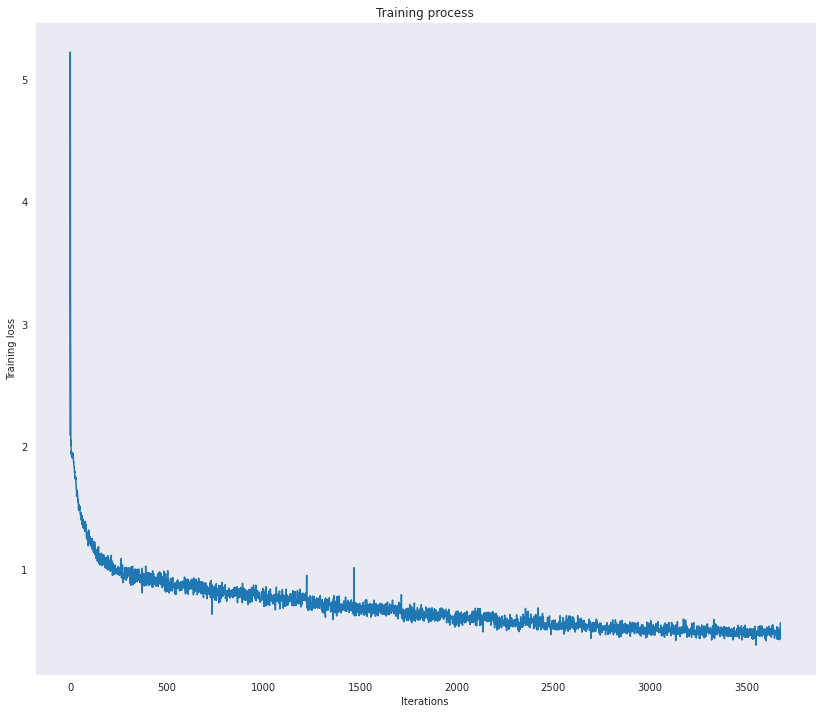

In [43]:
plt.figure(figsize=(14, 12))
plt.plot(cls_model.train_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Training loss');

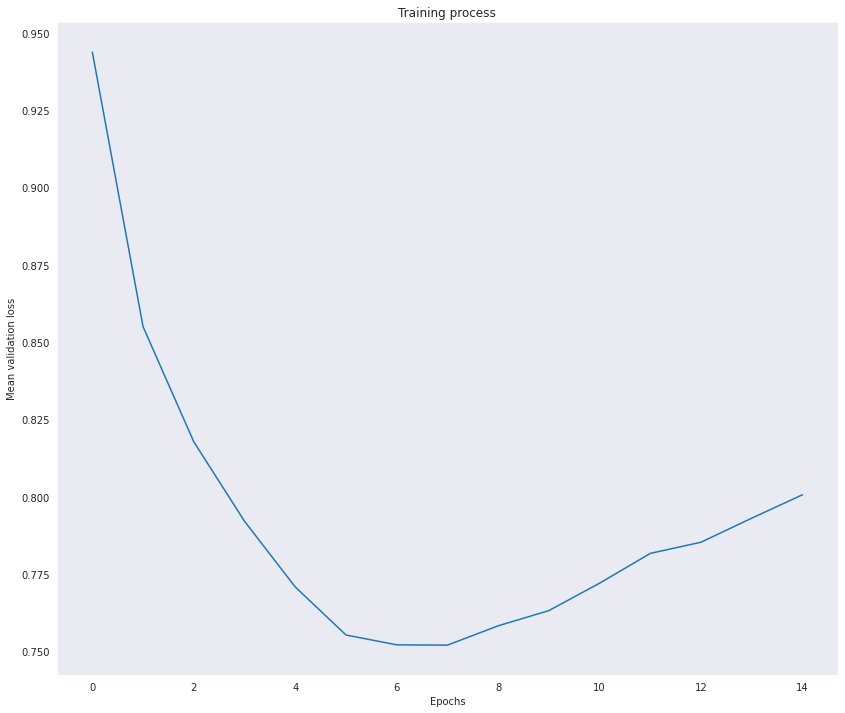

In [44]:
plt.figure(figsize=(14, 12))
plt.plot(cls_model.valid_epoch_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Epochs')
plt.ylabel('Mean validation loss');

We can see that overfitting started around epoch 8. Ideally, we should have stopped the training process at this stage or, better, cached the weights to use them for final evaluation and inference.

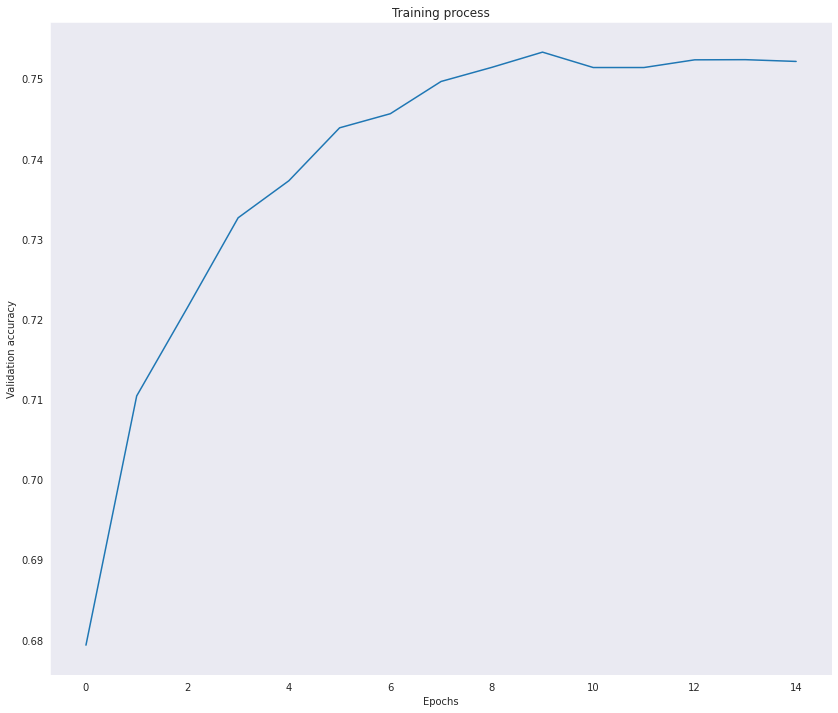

In [45]:
plt.figure(figsize=(14, 12))
plt.plot(cls_model.epoch_metrics)
plt.grid()
plt.title('Training process')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy');

In [46]:
valid_preds = np.concatenate([cls_model.predict(x) for x, _ in valid_loader])
print(valid_preds.shape)

(49986, 8)


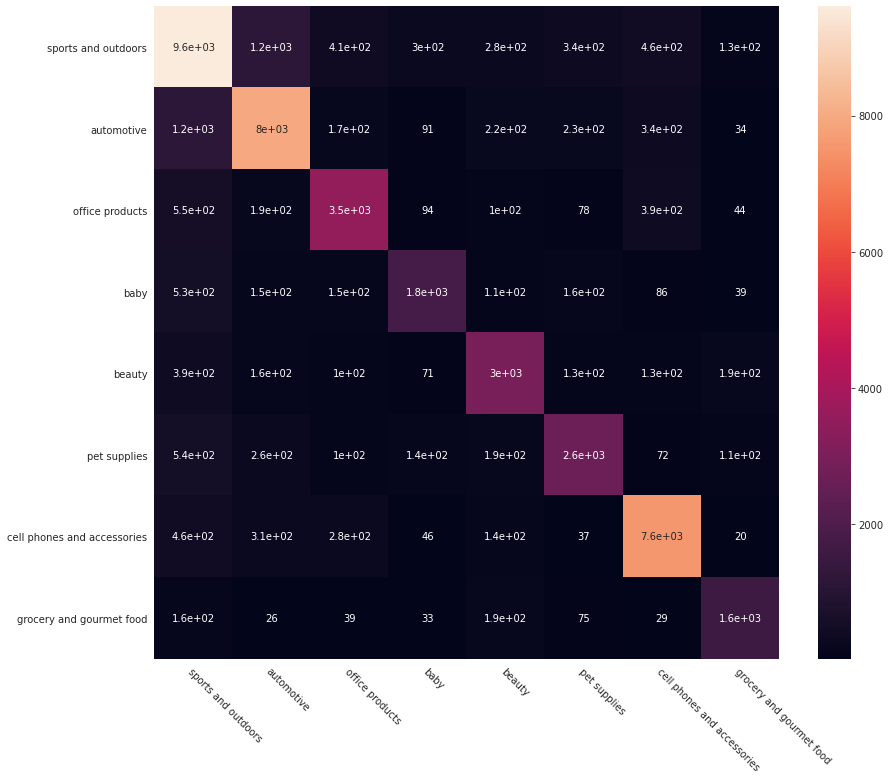

In [47]:
y_true = []
for _, y in valid_loader:
    y_true.extend(y.tolist())

cf_matrix = confusion_matrix(np.array(y_true), valid_preds.argmax(1))

f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cf_matrix, annot=True, xticklabels=category2index, yticklabels=category2index);
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor');

# What I did:

- training and validation loops
- logging (training loss (per iteration and per epoch), running average of training loss in a progress bar, mean validation loss, validation accuracy)
- if-based early stopping
- plots and confusion matrix
- model: pretrained + finetuned embeddings that were additionally trained along with the model, spatial dropout, bidirectional 2-layer LSTM with regular dropout, residual connection, and packed sequences as input
- training with different learning rates for the embeddings and for the rest of the model
- scheduler based on mean validation loss: every epoch, when the observed value is not less than 90% of the best observed value, the learning rate decreases by half
- training on GPU (RTX 2080 Ti)

# What I experimented with:

- batch size: the goal was to achieve the largest possible batch size to boost training efficiency and speed
- sequence packing: packing allowed to boost training speed just a little bit; however, it took a while to make it work correctly
- learning rate: it's a good idea to start with a slightly high learning rate and then lower it with a scheduler; for pretrained embeddings, learning rate should be low so we do not shift too far away from the corpus wisdom they encode
- dropout rate: using too high values will lead to underfitting, while using too low values may lead to overfitting; with this model, a lower dropout rate seems to work better
- device: obviously, training on GPU is significantly faster